<a href="https://colab.research.google.com/github/yashyasviagarwal/TcsHumain/blob/master/Lpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PLATE** **DETECTION** 

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [121]:
#Load Database
!git clone https://github.com/yashyasviagarwal/TcsHumainDatabase

Cloning into 'TcsHumainDatabase'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [122]:
cd TcsHumainDatabase

/content/TcsHumainDatabase


In [0]:
#Create Dataframe
import requests
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import urllib
import cv2


import json

# Read the data
data = pd.read_json('Indian_Number_plates.json', lines=True)
pd.set_option('display.max_colwidth', -1)

# Delete the empty column
del data['extras']

# Extract the points of the bounding boxes because thats what we want
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

# And drop the rest of the annotation info
del data['annotation']


Images = []
Plates = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))

        # We append the image to the training input array
        Images.append(im)  

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]

        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))
downloadTraining(data)

(417, 769)


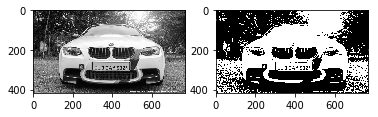

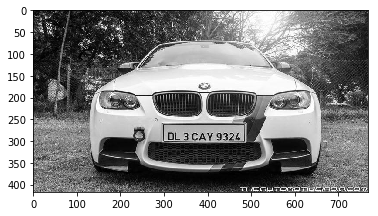

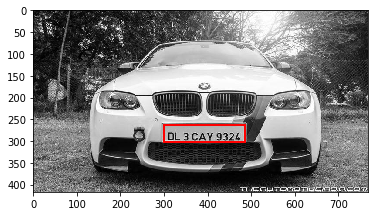

In [124]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt


filename = Image.fromarray(Images[16])#74


# car image -> grayscale image -> binary image
import imutils
filename.save("car.png")
car_image = imread("car.png", as_gray=True)
car_image = imutils.rotate(car_image, 0)
# car_image = imread("car.png", as_gray=True)
# it should be a 2 dimensional array
print(car_image.shape)

# the next line is not compulsory however, a grey scale pixel
# in skimage ranges between 0 & 1. multiplying it with 255
# will make it range between 0 & 255 (something we can relate better with

gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
# print(binary_car_image)
ax2.imshow(binary_car_image, cmap="gray")
# ax2.imshow(gray_car_image, cmap="gray")
plt.show()

# CCA (finding connected regions) of binary image


from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)

# print(label_image.shape[0]) #width of car img

# getting the maximum width, height and minimum width and height that a license plate can be
plate_dimensions = (0.03*label_image.shape[0], 0.08*label_image.shape[0], 0.15*label_image.shape[1], 0.3*label_image.shape[1])
plate_dimensions2 = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []

fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")
flag =0
# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    # print(region)
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue
        # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    # print(min_row)
    # print(min_col)
    # print(max_row)
    # print(max_col)

    region_height = max_row - min_row
    region_width = max_col - min_col
    # print(region_height)
    # print(region_width)

    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        flag = 1
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                         max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
        # let's draw a red rectangle over those regions
if(flag == 1):
    # print(plate_like_objects[0])
    plt.show()




if(flag==0):
    min_height, max_height, min_width, max_width = plate_dimensions2
    plate_objects_cordinates = []
    plate_like_objects = []

    fig, (ax1) = plt.subplots(1)
    ax1.imshow(gray_car_image, cmap="gray")

    # regionprops creates a list of properties of all the labelled regions
    for region in regionprops(label_image):
        if region.area < 50:
            #if the region is so small then it's likely not a license plate
            continue
            # the bounding box coordinates
        min_row, min_col, max_row, max_col = region.bbox
        # print(min_row)
        # print(min_col)
        # print(max_row)
        # print(max_col)

        region_height = max_row - min_row
        region_width = max_col - min_col
        # print(region_height)
        # print(region_width)

        # ensuring that the region identified satisfies the condition of a typical license plate
        if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
            # print("hello")
            plate_like_objects.append(binary_car_image[min_row:max_row,
                                      min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,
                                             max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                           linewidth=2, fill=False)
            ax1.add_patch(rectBorder)
            # let's draw a red rectangle over those regions
    # print(plate_like_objects[0])
    plt.show()

# **CHARACTER** **SEGMENTATION**

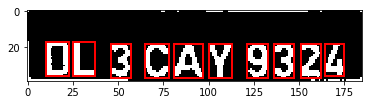

In [125]:
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# The invert was done so as to convert the black pixel to white pixel and vice versa
if(len(plate_like_objects)>0):
  for i in range(len(plate_like_objects)):
    license_plate = np.invert(plate_like_objects[i])

    labelled_plate = measure.label(license_plate)

    fig, ax1 = plt.subplots(1)
    ax1.imshow(license_plate, cmap="gray")
    # the next two lines is based on the assumptions that the width of
    # a license plate should be between 5% and 15% of the license plate,
    # and height should be between 35% and 60%
    # this will eliminate some
    character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions

    characters = []
    counter=0
    column_list = []
    for regions in regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            roi = license_plate[y0:y1, x0:x1]

            # draw a red bordered rectangle over the character.
            rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                           linewidth=2, fill=False)
            ax1.add_patch(rect_border)

            # resize the characters to 20X20 and then append each character into the characters list
            resized_char = resize(roi, (20, 20))
            characters.append(resized_char)

            # this is just to keep track of the arrangement of the characters
            column_list.append(x0)
    # print(characters)
    plt.show()
else:
  print("PLATE NOT DETECTED")

# **TRAIN** **THE** **MODEL**

In [127]:
!unzip train20X20.zip

Archive:  train20X20.zip
   creating: train20X20/
   creating: train20X20/R/
  inflating: train20X20/R/R_9.jpg    
   creating: __MACOSX/
   creating: __MACOSX/train20X20/
   creating: __MACOSX/train20X20/R/
  inflating: __MACOSX/train20X20/R/._R_9.jpg  
  inflating: train20X20/R/R_8.jpg    
  inflating: __MACOSX/train20X20/R/._R_8.jpg  
  inflating: train20X20/R/R_6.jpg    
  inflating: __MACOSX/train20X20/R/._R_6.jpg  
  inflating: train20X20/R/R_7.jpg    
  inflating: __MACOSX/train20X20/R/._R_7.jpg  
  inflating: train20X20/R/R_5.jpg    
  inflating: __MACOSX/train20X20/R/._R_5.jpg  
  inflating: train20X20/R/R_4.jpg    
  inflating: __MACOSX/train20X20/R/._R_4.jpg  
  inflating: train20X20/R/R_0.jpg    
  inflating: __MACOSX/train20X20/R/._R_0.jpg  
  inflating: train20X20/R/R_1.jpg    
  inflating: __MACOSX/train20X20/R/._R_1.jpg  
  inflating: train20X20/R/R_3.jpg    
  inflating: __MACOSX/train20X20/R/._R_3.jpg  
  inflating: train20X20/R/R_2.jpg    
  inflating: __MACOSX/train

In [128]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu

letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_directory, each_letter, each_letter + '_' + str(each) + '.jpg')
            # read each image of each character
            img_details = imread(image_path, as_gray=True)
            # converts each character image to binary image
            binary_image = img_details < threshold_otsu(img_details)
            # the 2D array of each image is flattened because the machine learning
            # classifier requires that each sample is a 1D array
            # therefore the 20*20 image becomes 1*400
            # in machine learning terms that's 400 features with each pixel
            # representing a feature
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)

    return (np.array(image_data), np.array(target_data))

def cross_validation(model, num_of_fold, train_data, train_label):
    # this uses the concept of cross validation to measure the accuracy
    # of a model, the num_of_fold determines the type of validation
    # e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
    # it will divide the dataset into 4 and use 1/4 of it for testing
    # and the remaining 3/4 for the training
    accuracy_result = cross_val_score(model, train_data, train_label,
                                      cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)


# current_dir = os.path.dirname(os.path.realpath(__file__))
#
# training_dataset_dir = os.path.join(current_dir, 'train')
print('reading data')
training_dataset_dir = './train20X20'
image_data, target_data = read_training_data(training_dataset_dir)
print('reading data completed')

# the kernel can be 'linear', 'poly' or 'rbf'
# the probability was set to True so as to show
# how sure the model is of it's prediction
svc_model = SVC(kernel='linear', probability=True)

cross_validation(svc_model, 4, image_data, target_data)

print('training model')

# let's train the model with all the input data
svc_model.fit(image_data, target_data)

reading data
reading data completed
Cross Validation Result for  4  -fold
[ 96.07843137  99.01960784  97.05882353 100.        ]
training model


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# **PREDICTION**

In [129]:
import pickle
print("Loading model")
model = svc_model

print('Model loaded. Predicting characters of number plate')
classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print('Classification result')
print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print('Predicted license plate')
print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print('License plate')
print(rightplate_string)

Loading model
Model loaded. Predicting characters of number plate
Classification result
[array(['D'], dtype='<U1'), array(['L'], dtype='<U1'), array(['3'], dtype='<U1'), array(['C'], dtype='<U1'), array(['A'], dtype='<U1'), array(['Y'], dtype='<U1'), array(['9'], dtype='<U1'), array(['3'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['4'], dtype='<U1')]
Predicted license plate
DL3CAY93Z4
License plate
DL3CAY93Z4


# **Check If Vehicle Is Stolen**

In [130]:
!pip install bs4

In [131]:
import requests 
from bs4 import BeautifulSoup
import re
#removing all nonalpha numeric characters

rightplate_string=re.sub("[^A-Za-z0-9]","",rightplate_string)
print(" ")



query="DL2SP3463"#stolen vehicle present in database
#query=rightplate_string#uncomment to use detected plate as query(might not be present in database as it may not be stolen)

URL = "https://www.zipnet.in/index.php?page=stolen_vehicles_search&criteria=search&rg_no="+query
r = requests.get(URL,allow_redirects = True,verify=False)
soup = BeautifulSoup(r.content, 'html5lib')
table=soup.find(lambda tag:tag.name=="table" and "State" in tag.text,{"id": "AutoNumber6"})
if table==None:
  print(" ")
  print("Vehicle Not Found In The Database")
else:
  tbody=table.find('tbody')
  tbody2=tbody.find('tbody')
  tr1=tbody2.findAll('tr')
  dictionary={}
  for tr in tr1:
    td=tr.findAll('td')
    for i in range(0,len(td),2):
      dictionary[td[i].text.strip()]=td[i+1].text.strip()
  
  
  print(" ")
  print("STOLEN/LOST VEHICLE DETAILS ARE BELOW")
  print(" ")
  for key,value in dictionary.items():
    print(key,':',value)

 
 
STOLEN/LOST VEHICLE DETAILS ARE BELOW
 
Control Room No : 
State : DELHI
FIR Number : 028486
District : Crime Branch, Delhi
FIR Date : 08/12/2019
Police Station : e-Police Station MV Theft
Vehicle Type : SCOOTER
Registration Number : DL2SP3463
Vehicle Make : HONDA MOTORCYCLE AND SCOOTER
Engine Number : JF50E83054764
Vehicle Model : Not Availa
Chassis Number : ME4JF505CG8054445
Vehicle Color : BROWN
Phone Number : 9999071122
Complainant : Prem Prakash Kaim
Address : 500/3 C-1 block-30 street no-7, vishwas nagar, shahdara,east delhi-110032
Stolen From : 153/2,patparganj village,mayur vihar ph-1,delhi-91
Status : Stolen
Report Date/Time on ZIPNET : 12/08/2019 12:00.00 AM
